import libraries

In [199]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as keras_layer, Sequential, optimizers, losses, callbacks
from tensorflow.keras.losses import mae, mse, BinaryCrossentropy, CategoricalCrossentropy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import glob
import random

read and load images function

In [200]:
image_size = (224, 224)
def read_load_images(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, image_size)
    return img

In [201]:
load_image = read_load_images("./dataset/valid/images/Frame_108.jpg")

load and process labels function

In [202]:
def load_process_label(label_path):
    with open(label_path, "r") as file:
        lines = file.readlines()

        label_values = [list(map(float, label.strip().split())) for label in lines]
        label_array = np.array(label_values).flatten()

        return label_array[1:]

In [203]:
load_label = load_process_label("./dataset/valid/labels/Frame_108.txt")

draw the bounding box of images function

In [204]:
def draw_bounding_box(img, label, color=(255,0,0)):
    class_id = int(label[0])
    x_center, y_center, width, height = map(float, label)

    img_w, img_h = image_size
    x_center, y_center = int(x_center * img_w), int(y_center * img_h)
    width, height = int(width * img_w), int(height * img_h)

    x1, y1 = x_center - width // 2, y_center - height // 2
    x2, y2 = x_center + width // 2, y_center + height // 2

    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    return img

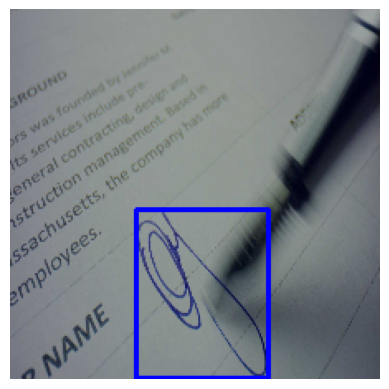

In [205]:
image_bounding_box = draw_bounding_box(load_image, load_label)

plt.imshow(cv2.cvtColor(image_bounding_box, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

define train and validation dataset variables

In [206]:
images_train_dir = "./dataset/train/images"
labels_train_dir = "./dataset/train/labels"

images_valid_dir = "./dataset/valid/images"
labels_valid_dir = "./dataset/valid/labels"

set image and label pairs

In [207]:
def get_image_labels_pairs(image_dir, label_dir):
  image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
  label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))

  image_label_pairs = []
  for img_path in image_paths:
    base_name = os.path.basename(img_path).split('.')[0]

    label_path = os.path.join(label_dir, base_name + ".txt")

    image_label_pairs.append((
      read_load_images(img_path),
      load_process_label(label_path)
    ))

  return image_label_pairs

In [208]:
train_data = get_image_labels_pairs(
    images_train_dir,
    labels_train_dir
)

In [209]:
len(train_data)

143

In [210]:
val_data = get_image_labels_pairs(
    images_valid_dir,
    labels_valid_dir
)

In [211]:
len(val_data)

35

split the train images data

train data

In [212]:
train_images, train_labels = zip(*train_data)

In [213]:
train_images = np.array(train_images).astype(np.float32) / 255.0
train_labels = np.array(train_labels).astype(np.float32)

In [214]:
len(train_images), len(train_labels)

(143, 143)

validation data

In [215]:
val_images, val_labels = zip(*val_data)

In [216]:
val_images = np.array(val_images).astype(np.float32) / 255.0
val_labels = np.array(val_labels).astype(np.float32)

In [217]:
len(val_images), len(val_labels)

(35, 35)

visualize random data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


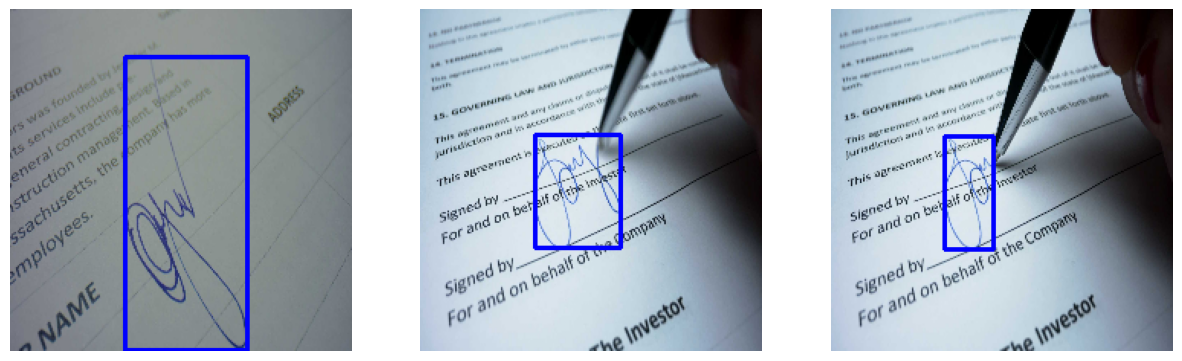

In [218]:
def plot_random_image(images, labels, show = 5, range_len = 10):
  random_indices = random.sample(range(0, range_len), show)
  fig, axes = plt.subplots(1, show, figsize=(15, 5))

  for i, idx in enumerate(random_indices):
      random_draw_ground = draw_bounding_box(images[idx], labels[idx])

      axes[i].imshow(cv2.cvtColor(random_draw_ground, cv2.COLOR_BGR2RGB))
      axes[i].axis("off")

  plt.show()

plot_random_image(train_images, train_labels, show = 3, range_len=142)

base model

In [219]:
model_1 = Sequential([
    keras_layer.Input(shape=(224, 224, 3)),
    keras_layer.Conv2D(64, 3, activation="relu", padding="same"),
    keras_layer.MaxPool2D(),
    keras_layer.Conv2D(128, 3, activation="relu", padding="same"),
    keras_layer.MaxPool2D(),
    keras_layer.Conv2D(256, 3, activation="relu", padding="same"),
    keras_layer.MaxPool2D(),
    keras_layer.Conv2D(512, 3, activation="relu", padding="same"),
    keras_layer.MaxPool2D(),
    keras_layer.GlobalAveragePooling2D(),
    keras_layer.Dense(512, activation = "relu"),
    keras_layer.Dropout(0.5),
    keras_layer.Dense(4, activation="linear")
])

In [220]:
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,815,684 (6.93 MB)

 Trainable params: 1,815,684 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

In [221]:
model_1.compile(
    loss = losses.huber,
    optimizer = optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy", "mae"]
)

In [222]:
history_model_1 = model_1.fit(
    train_images,
    train_labels,
    epochs = 50,
    batch_size = 8
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.5729 - loss: 0.1335 - mae: 0.3823
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - accuracy: 0.6336 - loss: 0.1135 - mae: 0.2957
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step - accuracy: 0.6201 - loss: 0.0478 - mae: 0.2495
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 510ms/step - accuracy: 0.6518 - loss: 0.0267 - mae: 0.1535
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step - accuracy: 0.5734 - loss: 0.0241 - mae: 0.1557
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step - accuracy: 0.7007 - loss: 0.0197 - mae: 0.1500
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - accuracy: 0.5641 - loss: 0.0271 - mae: 0.1566
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 514ms/step - accuracy: 0.5474 - loss: 0.0203 - mae: 0.1508
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step - accuracy: 0.6895 - loss: 0.0210 - mae: 0.1501
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 537ms/step - accuracy: 0.7165 - loss: 0.0195 - mae: 0.14

evaluate the model

In [223]:
model_1.evaluate(val_images, val_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5286 - loss: 0.0021 - mae: 0.0497


[0.0021773295011371374, 0.5428571701049805, 0.05077659338712692]

In [224]:
model_1_preds_probs = model_1.predict(val_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


In [225]:
model_1_preds_probs[:5]

array([[0.5073225 , 0.713997  , 0.31548902, 0.5832086 ],
       [0.5072457 , 0.7180919 , 0.31134772, 0.57447517],
       [0.5406254 , 0.64580643, 0.3854869 , 0.77700007],
       [0.5563657 , 0.6311445 , 0.40956566, 0.83986354],
       [0.55551136, 0.6293757 , 0.40910104, 0.8389166 ]], dtype=float32)

In [226]:
val_labels[:5]

array([[0.51875 , 0.769907, 0.3625  , 0.460185],
       [0.516406, 0.765741, 0.367188, 0.468519],
       [0.517188, 0.656019, 0.365625, 0.687963],
       [0.517708, 0.569907, 0.364583, 0.860185],
       [0.517708, 0.569907, 0.364583, 0.860185]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


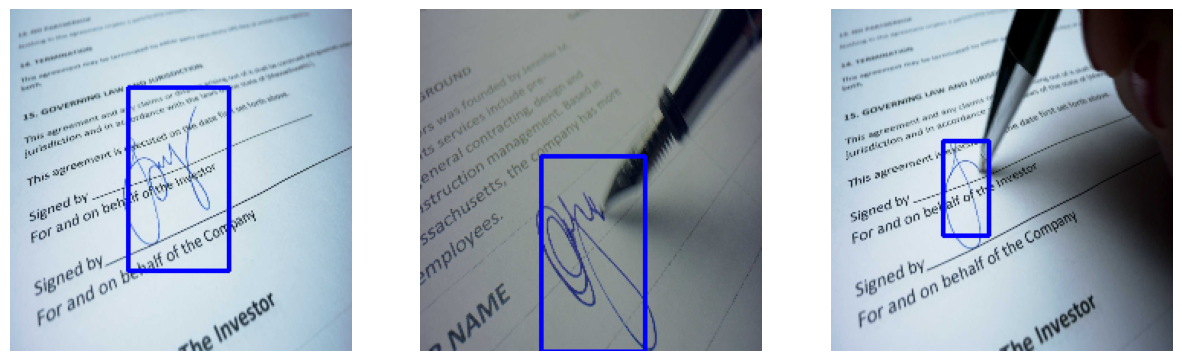

In [227]:
plot_random_image(val_images, model_1_preds_probs, show=3, range_len=30)

In [229]:
model_1.save("cnn_signature_model_v1.keras")